# Price Prediction for NVIDIA Stock

In [25]:
# Import libraries
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing, cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [26]:
#Read the data file
df = pd.read_csv('data/NVDA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-07,13.38,13.49,12.95,13.40,12.349566,19526600
1,2012-09-10,13.37,13.56,13.25,13.28,12.238974,9277700
2,2012-09-11,13.27,13.65,13.22,13.44,12.386427,9570200
3,2012-09-12,13.55,13.66,13.42,13.59,12.524673,8065200
4,2012-09-13,13.71,13.76,13.42,13.68,12.607616,10845900


In [27]:
#setting date as index
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df.drop(['Date'], axis=1, inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-09-07,13.38,13.49,12.95,13.40,12.349566,19526600
2012-09-10,13.37,13.56,13.25,13.28,12.238974,9277700
2012-09-11,13.27,13.65,13.22,13.44,12.386427,9570200
2012-09-12,13.55,13.66,13.42,13.59,12.524673,8065200
2012-09-13,13.71,13.76,13.42,13.68,12.607616,10845900


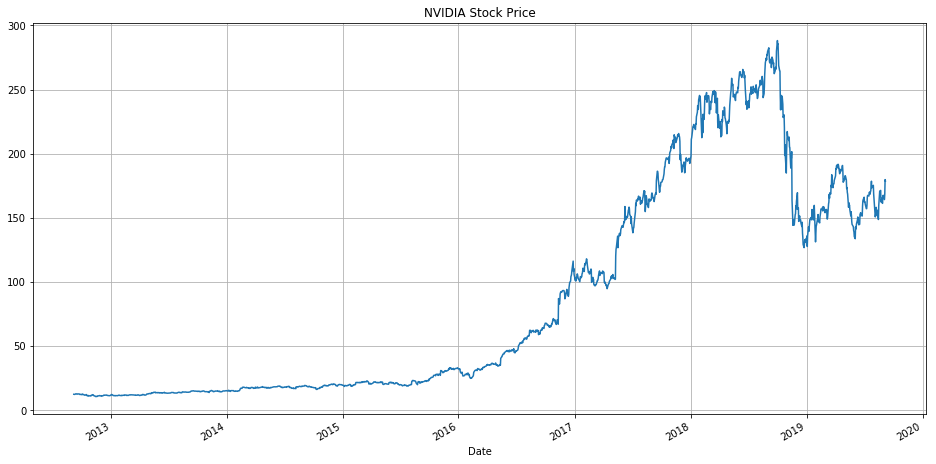

In [28]:
# Plot Adjusted Closing Price
df['Adj Close'].plot(label='NVDA', figsize=(16,8), title='NVIDIA Stock Price', grid=True)

In [29]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [30]:
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2012-09-07,12.349566,19526600,4.029851,0.149477
2012-09-10,12.238974,9277700,2.334337,-0.673149
2012-09-11,12.386427,9570200,3.199405,1.281085
2012-09-12,12.524673,8065200,1.766004,0.295203
2012-09-13,12.607616,10845900,2.485380,-0.218818


### Linear Regression Prediction

In [31]:
dfreg_1 = dfreg.copy()

# Drop missing value
dfreg_1.fillna(value=-99999, inplace=True)

# Separate 5 percent of the data to forecast
forecast_out = int(math.ceil(0.05 * len(dfreg_1)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg_1['label'] = dfreg_1[forecast_col].shift(-forecast_out)
X = np.array(dfreg_1.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg_1['label'])
y = y[:-forecast_out]

In [32]:
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

In [33]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

confidencereg = clfreg.score(X_test, y_test)

print("Linear Regression Confidence = ",confidencereg)

Linear Regression Confidence =  0.8627688525234444


In [34]:
# Printing the linear regression forecast
forecast_set = clfreg.predict(X_lately)
dfreg_1['Forecast'] = np.nan
print(forecast_set, confidencereg, forecast_out)

[176.85301456 171.97908571 171.12256974 167.68173317 174.09141606
 165.69638396 161.75682219 162.49848121 162.10244962 173.8351226
 171.46171379 157.07551723 152.7909391  149.22324528 152.07731616
 139.86106207 142.92933681 146.0477723  136.8397021  132.43967049
 133.78188594 142.75132089 139.04597248 143.5696346  142.07223261
 147.76506203 149.65176874 143.32078506 145.19631623 145.70031653
 140.20145696 149.39993663 150.7077878  150.02046619 151.18166757
 147.04691457 144.18794666 161.2243209  164.97289528 163.21617284
 166.40946399 158.14186489 154.95576492 159.69639071 154.59602226
 153.31216137 159.90509573 170.73183114 171.0830608  161.27322295
 162.63252995 163.88606724 167.00973333 163.28433935 166.32469073
 174.09856001 172.07307233 167.50612639 168.65517312 163.90466836
 163.35695976 157.33072959 150.61937785 158.17511174 155.07499476
 145.68793116 147.4878601  150.57551986 147.95137213 144.69424168
 142.20676389 147.45274588 149.69273009 182.77414436 177.80979945
 168.499512

In [35]:
last_date = dfreg_1.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg_1.loc[next_date] = [np.nan for _ in range(len(dfreg_1.columns)-1)]+[i]

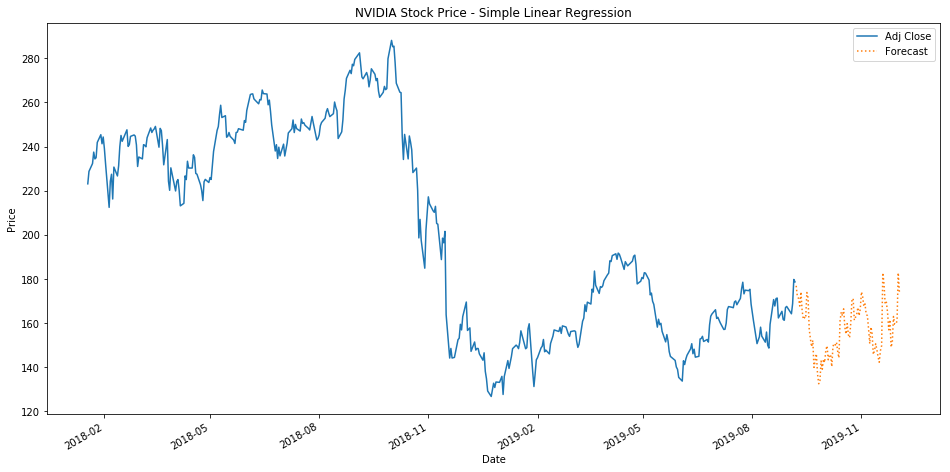

In [36]:
dfreg_1['Adj Close'].tail(500).plot(figsize=(16,8))
dfreg_1['Forecast'].tail(500).plot(ls=':')
plt.title('NVIDIA Stock Price - Simple Linear Regression')
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Lasso Regression Prediction

In [37]:
dfreg_2 = dfreg.copy()

# Drop missing value
dfreg_2.fillna(value=-99999, inplace=True)

# Separate 5 percent of the data to forecast
forecast_out = int(math.ceil(0.05 * len(dfreg_2)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg_2['label'] = dfreg_2[forecast_col].shift(-forecast_out)
X = np.array(dfreg_2.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg_2['label'])
y = y[:-forecast_out]

In [38]:
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

In [39]:
# Lasso Regression
clflasso = Lasso(alpha=0.1)
clflasso.fit(X_train, y_train)

confidencelasso = clflasso.score(X_test,y_test)

print("Lasso Regression Confidence = ",confidencelasso)

Lasso Regression Confidence =  0.8722606027334754


In [40]:
# Printing the poly regression forecast
forecast_set = clflasso.predict(X_lately)
dfreg_2['Forecast'] = np.nan
print(forecast_set, confidencelasso, forecast_out)

[175.90171272 169.94518876 170.55832535 166.13188432 173.40253233
 164.34067198 161.54483001 161.34063771 161.55086303 173.63270629
 171.13262269 156.70712787 151.90094597 148.66425089 151.81533706
 139.18237036 142.54855345 145.76205096 136.10125794 131.69872986
 133.21220602 140.25346056 138.54140489 142.46898592 140.91859687
 146.92233031 148.93992586 142.87642984 144.26179314 145.14573751
 139.25108744 147.02202794 150.16295929 149.45519053 150.64178793
 146.08689484 143.16638456 159.93933995 164.37885698 162.625432
 165.85206431 157.53389535 153.95436632 159.06368376 153.96423653
 152.12872944 158.99184806 169.4135492  170.5809314  160.47986632
 161.65256158 162.44430832 165.95734339 162.71779547 165.15131578
 172.93163226 170.72113663 166.77598912 167.64692299 162.52812325
 161.65916889 156.29732257 148.91991958 157.15113807 154.84877368
 144.61463232 145.58663614 149.03248316 147.129416   143.71104151
 139.4265946  146.81980718 149.24726403 183.10376362 175.96545306
 168.1868210

In [41]:
last_date = dfreg_2.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg_2.loc[next_date] = [np.nan for _ in range(len(dfreg_2.columns)-1)]+[i]

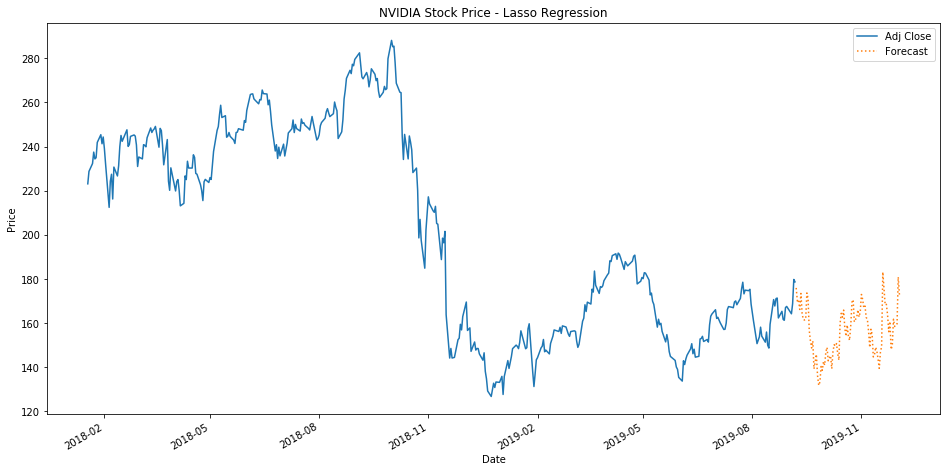

In [42]:
dfreg_2['Adj Close'].tail(500).plot(figsize=(16,8))
dfreg_2['Forecast'].tail(500).plot(ls=':')
plt.title('NVIDIA Stock Price - Lasso Regression')
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Polynomial Regression Prediction

In [43]:
dfreg_3 = dfreg.copy()

# Drop missing value
dfreg_3.fillna(value=-99999, inplace=True)

# Separate 5 percent of the data to forecast
forecast_out = int(math.ceil(0.05 * len(dfreg_3)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg_3['label'] = dfreg_3[forecast_col].shift(-forecast_out)
X = np.array(dfreg_3.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg_3['label'])
y = y[:-forecast_out]

In [44]:
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

In [45]:
# Polynomial Regression - Degree 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), LinearRegression())
clfpoly3.fit(X_train, y_train)

confidencepoly3 = clfpoly3.score(X_test,y_test)

print("Polynomial Regression (degree 3) Confidence = ",confidencepoly3)

Polynomial Regression (degree 3) Confidence =  0.9148717011592671


In [46]:
# Printing the poly regression forecast
forecast_set = clfpoly3.predict(X_lately)
dfreg_3['Forecast'] = np.nan
print(forecast_set, confidencepoly3, forecast_out)

[214.33829957 199.35880778 204.69635777 199.53470276 204.46652999
 193.217846   197.57709878 197.56157034 203.12332272 204.34646932
 189.44721743 195.36091525 198.74009266 197.54932154 189.42076413
 183.38896198 186.86881096 184.17744393 179.16916108 174.46060178
 172.8426683  162.97829442 178.1344021  187.11725994 186.32220619
 191.51455792 194.89891397 189.73670091 194.40469075 192.53072268
 189.000728   172.94693858 199.15474224 195.18490247 193.85768325
 194.14882773 186.57852932 192.53077558 210.06284782 207.96042737
 197.59041625 199.25031559 200.66558683 205.2913421  202.8040567
 197.98595433 200.65980367 197.21090986 213.39337961 206.16314157
 205.82762709 204.00021436 203.01378179 205.9938796  211.36794512
 215.17761692 206.60271995 204.27808666 213.17988276 200.20416504
 202.92961156 188.69831723 177.43337785 196.46581829 193.18138738
 185.30268227 185.6257077  191.57786126 190.16684246 190.27733829
 172.68516919 189.1436231  191.08586624 202.45617387 196.05759176
 211.232678

In [47]:
last_date = dfreg_3.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg_3.loc[next_date] = [np.nan for _ in range(len(dfreg_3.columns)-1)]+[i]

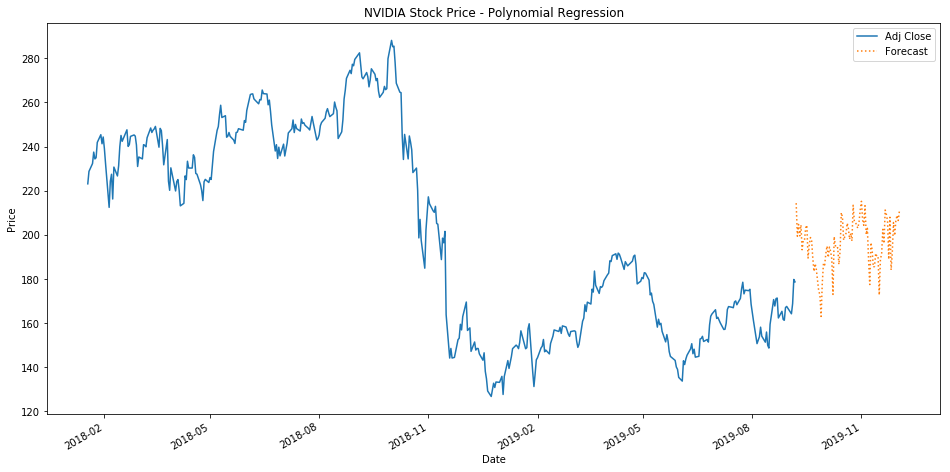

In [48]:
dfreg_3['Adj Close'].tail(500).plot(figsize=(16,8))
dfreg_3['Forecast'].tail(500).plot(ls=':')
plt.title('NVIDIA Stock Price - Polynomial Regression')
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()